## Normalization and Training/Validation Sets

This will be a quick intro on how to normalize data for use in the NN, as well as how to properly use training and validation sets.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import Utils as ut
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

epochs = 100
learning_rate = 0.0005
num_points = 10
num_nodes = 64
num_batch = 30
num_layers = 3

These are placeholders, they are like empty slots where we can feed things into the NN machinery

In [2]:
input_tf = tf.placeholder(tf.float32, [None,4])
output_tf = tf.placeholder(tf.float32, [None,2])

Making data to put input, using meshgrid to make all possible multiples of inputs. There is both real and imaginary parts for both x and y. 

Right after the z values are calculated (could be given to us as well) and everything is made into a column vector and stuck into a 6 column matrix

In [3]:
x_r = np.linspace(0, 20, num_points)
x_i = np.linspace(-10, 0, num_points)
y_r = np.linspace(-30, 10, num_points)
y_i = np.linspace(20, 30, num_points)
x_r, y_r, x_i, y_i = np.meshgrid(x_r, y_r, x_i, y_i)

x_r = x_r.reshape(-1,1)
x_i = x_i.reshape(-1,1)
y_r = y_r.reshape(-1,1)
y_i = y_i.reshape(-1,1)
z = (x_r+x_i*1j) + (y_r+y_i*1j)
data = np.hstack((x_r, x_i, y_r, y_i, z.real, z.imag))
np.random.shuffle(data)

Right here we split our data into a training set and a validation set. The training set is for actually training the NN, and the validation set is to make sure it isn't introducing bias into the network.

In [4]:
train_size = int(len(x_r) * 0.7)
data_tr = data[0:train_size]
data_val = data[train_size:]

Here is where the data is normalized, using a normalizer from sklearn. This one in particularly scales all the data to be within -1 and 1 (0 and 1 by default). Other normalizers will also modify std's along with scaling.

Notice the normalizer is formed from the training set only, and then applied to both the training set and validation set.

In [5]:
norm = MinMaxScaler(copy=True, feature_range=(-1,1))
norm.fit(data_tr)
data_tr = norm.transform(data_tr)
data_val = norm.transform(data_val)

Here is where are layers are made, using the make_layer function found in the Utilities.py file. Note that there's 4 inputs, and make make "num_layers" layers and "num_nodes" nodes per layer, and then an output of 2, one real and one imaginary.

In [6]:
input = ut.make_layer(tf.nn.leaky_relu, input_tf, 4, num_nodes)
hidden = [input]
for i in range(num_layers):
    hidden += [ut.make_layer(tf.nn.leaky_relu, hidden[-1], num_nodes, num_nodes)]
output = ut.make_layer(ut.linear, hidden[-1], num_nodes, 2)

Here's where our loss functions are made using MSE, one for the real part and one for the imaginary. Notice that we will be comparing the output that we put in (using the output_tf placeholder) and the output the NN will spit out.

$R^2$ is also calculated here using the make_r function also found in Utilities.py.

In [7]:
loss_real = tf.losses.mean_squared_error(output_tf[:,0:1], output[:,0:1])
loss_imag = tf.losses.mean_squared_error(output_tf[:,1:2], output[:,1:2])
train = tf.train.AdamOptimizer(learning_rate).minimize(loss_imag+loss_real)

r = ut.make_r(output_tf, output)

This is where the magic happens. We'll begin a session to start training our neural network. All the empty lists will be used to store the loss and $R^2$ value at each epoch.

The first for loop runs it through each epoch exactly once, while the second runs it through all the differents batches. Note inside the second for loop we're doing "sess.run" on the train object, and passing in only values from the training set.

Later on we pass the loss functions and $R^2$ function to store those for later. There's also some if statement to exit session early if the loss function's decrease stagnates. And at the end after all the epoch are ran, the actual data is stored to use in plotting later.

In [8]:
init = tf.global_variables_initializer()

batch_size = len(data_tr) // num_batch
with tf.Session() as sess:
    sess.run(init)
    plot_epoch = []
    plot_loss_tr = []
    plot_loss_val = []
    plot_r_tr = []
    plot_r_val = []
    count = 0
    for i in range(epochs+1):
        for j in range(0,len(data_tr), batch_size):
            sess.run(train, feed_dict={input_tf: data_tr[j:j+batch_size,0:4], output_tf: data_tr[j:j+batch_size,4:6]})

        #get losses
        plot_epoch += [i]
        temp1, temp2 = sess.run([loss_real,loss_imag], feed_dict={input_tf: data_tr[:,0:4], output_tf: data_tr[:,4:6]})
        plot_loss_tr += [temp1 + temp2]
        temp1, temp2 = sess.run([loss_real,loss_imag], feed_dict={input_tf: data_val[:,0:4], output_tf: data_val[:,4:6]})
        plot_loss_val += [temp1 + temp2]
        #get r
        plot_r_tr += sess.run([r], feed_dict={input_tf: data_tr[:,0:4], output_tf: data_tr[:,4:6]})
        plot_r_val += sess.run([r], feed_dict={input_tf: data_val[:,0:4], output_tf: data_val[:,4:6]})
        #jump ship if it's good enough
        if len(plot_loss_tr) > 1 and abs(plot_loss_tr[-1]-plot_loss_tr[-2]) < 0.00001:
            count += 1
        else:
            count = 0
        if count >= 2:
            break

        if i % 1 == 0:
            print("Epoch: %s \t TLoss: %s \t VLoss: %s" % (i, plot_loss_tr[-1], plot_loss_val[-1]))

    #get predictions
    pred_tr = sess.run([output], feed_dict={input_tf: data_tr[:,0:4], output_tf: data_tr[:,4:6]})
    pred_val = sess.run([output], feed_dict={input_tf: data_val[:,0:4], output_tf: data_val[:,4:6]})

Epoch: 0 	 TLoss: 0.41862875 	 VLoss: 0.4290147
Epoch: 1 	 TLoss: 0.24401551 	 VLoss: 0.2530969
Epoch: 2 	 TLoss: 0.026077643 	 VLoss: 0.027786449
Epoch: 3 	 TLoss: 0.009532744 	 VLoss: 0.009824067
Epoch: 4 	 TLoss: 0.006139253 	 VLoss: 0.0063460823
Epoch: 5 	 TLoss: 0.0035580895 	 VLoss: 0.0037415503
Epoch: 6 	 TLoss: 0.0017268241 	 VLoss: 0.0018575486
Epoch: 7 	 TLoss: 0.00081736955 	 VLoss: 0.00090490415
Epoch: 8 	 TLoss: 0.0004744972 	 VLoss: 0.0005331619
Epoch: 9 	 TLoss: 0.00034298177 	 VLoss: 0.00038589467
Epoch: 10 	 TLoss: 0.00027627326 	 VLoss: 0.0003102845
Epoch: 11 	 TLoss: 0.00022787362 	 VLoss: 0.00025556472
Epoch: 12 	 TLoss: 0.00019121196 	 VLoss: 0.00021368061
Epoch: 13 	 TLoss: 0.0001638331 	 VLoss: 0.00018215031
Epoch: 14 	 TLoss: 0.00014182209 	 VLoss: 0.00015680338
Epoch: 15 	 TLoss: 0.00012374108 	 VLoss: 0.00013587737
Epoch: 16 	 TLoss: 0.00010871941 	 VLoss: 0.00011848446
Epoch: 17 	 TLoss: 9.6303076e-05 	 VLoss: 0.00010419918
Epoch: 18 	 TLoss: 8.5894324e-05 	 

This is where everything is plotted, including MSE, $R^2$, and the comparison between training and validation predictions

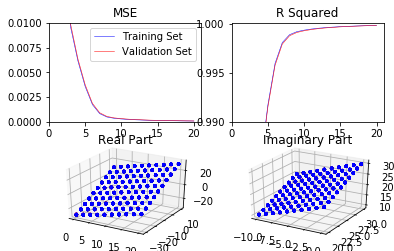

In [9]:
ax1 = plt.subplot(221)
ax1.plot(plot_epoch, plot_loss_tr, 'b-', lw=0.5, label="Training Set")
ax1.plot(plot_epoch, plot_loss_val,'r-', lw=0.5, label="Validation Set")
ax1.axis([0,len(plot_epoch),0,.01])
ax1.legend(loc="upper right")
ax1.set_title("MSE")

ax2 = plt.subplot(222)
ax2.plot(plot_epoch, plot_r_tr,'b-', lw=0.5)
ax2.plot(plot_epoch, plot_r_val,'r-', lw=0.5)
ax2.axis([0,len(plot_epoch),0.99,1.0001])
ax2.set_title("R Squared")

ax3 = plt.subplot(2, 2, 3, projection='3d')
ax3.set_title("Real Part")
ax4 = plt.subplot(2, 2, 4, projection='3d')
ax4.set_title("Imaginary Part")

data_tr[:,4:6] = np.array(pred_tr)
data_tr = norm.inverse_transform(data_tr)
ax3.scatter3D(data_tr[:,0:1], data_tr[:,2:3], data_tr[:,4:5], marker=".", c='b')
ax4.scatter3D(data_tr[:,1:2], data_tr[:,3:4], data_tr[:,5:6], marker=".", c='b')

data_val[:,4:6] = np.array(pred_val)
data_val = norm.inverse_transform(data_val)
ax3.scatter3D(data_val[:,0:1], data_val[:,2:3], data_val[:,4:5], marker=".", c='r')
ax4.scatter3D(data_val[:,1:2], data_val[:,3:4], data_val[:,5:6], marker=".", c='r')

plt.show()